# Belastingen uit RWS

#  importeer de benodigde functies

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from toolbox_continu_inzicht import Config, datetime_from_epoch

## 1. Voorbeeld met CSV
Lees de configuratie in:

Dit leest een configuratie bestand `belasting_rws_config.yaml` in. 
```yaml
GlobalVariables:
    rootdir: "data_sets" 
    moments: [-24,0,24,48]  

    csv:
        delimiter: ","

    LoadsWaterwebservicesRWS:
        MISSING_VALUE: 999999999.0 

DataAdapter: 
    locaties: 
        type: csv
        path: "belastingen_rws.csv"
    waterstanden: 
        type: csv
        path: "waterstanden.csv"
...

```

In [2]:
test_data_sets_path = Path.cwd() / "data_sets"
c = Config(config_path=test_data_sets_path / "loads_rws_config.yaml")
c.lees_config()

Zet de data adapter klaar en geef deze de configuratie mee 

In [3]:
from toolbox_continu_inzicht import DataAdapter

data = DataAdapter(config=c)

Run de module met CSV

In [4]:
from toolbox_continu_inzicht.loads import LoadsWaterwebservicesRWS

RWS_webservice = LoadsWaterwebservicesRWS(
    data_adapter=data, input="BelastingLocaties", output="Waterstanden"
)

In [5]:
RWS_webservice.df_in

In [6]:
lst_data = await RWS_webservice.run()

In [7]:
RWS_webservice.df_in

,index,measuringstationid
0,0,9889
1,1,8420
2,2,8411
3,2,8536


In [8]:
df_out = RWS_webservice.df_out.copy()

In [9]:
from toolbox_continu_inzicht.loads.loads_rws_webservice.get_rws_webservices_locations import (
    get_rws_webservices_locations,
)

df_loc = await get_rws_webservices_locations()

In [10]:
df_loc.columns

Index(['Coordinatenstelsel', 'X', 'Y', 'Naam', 'Code'], dtype='object')

In [11]:
df_loc.loc[8420]

Coordinatenstelsel             25831
X                      667699.101552
Y                     5742683.928092
Naam                       Lith Dorp
Code                            LITO
Name: 8420, dtype: object

In [12]:
df_out

,objectid,objecttype,parameterid,datetime,value,calculating,measurementcode
0,8420,measuringstation,1,1.729672e+12,121.0,True,WATHTEVERWACHT
1,8420,measuringstation,1,1.729672e+12,120.0,True,WATHTEVERWACHT
2,8420,measuringstation,1,1.729673e+12,120.0,True,WATHTEVERWACHT
3,8420,measuringstation,1,1.729673e+12,120.0,True,WATHTEVERWACHT
4,8420,measuringstation,1,1.729674e+12,119.0,True,WATHTEVERWACHT
...,...,...,...,...,...,...,...
1139,8536,measuringstation,1,1.729672e+12,-1.0,True,WATHTE
1140,8536,measuringstation,1,1.729673e+12,-2.0,True,WATHTE
1141,8536,measuringstation,1,1.729673e+12,-2.0,True,WATHTE
1142,8536,measuringstation,1,1.729674e+12,-2.0,True,WATHTE


In [13]:
# split de dataframe in tweeën & process
values_nan = df_out[df_out["value"] == 999999999.0].index
for val in values_nan:
    df_out.loc[val, "value"] = np.nan
df_out.sort_index()
df_plot = df_out.set_index(df_out["datetime"].apply(lambda x: datetime_from_epoch(x)))
df_plot = df_plot[df_plot["objectid"] == 8420]
measurement_index = df_plot["measurementcode"] == "WATHTEVERWACHT"
df_plot_measurements = df_plot[measurement_index][["value"]]
df_plot_forecast = df_plot[~measurement_index][["value"]]

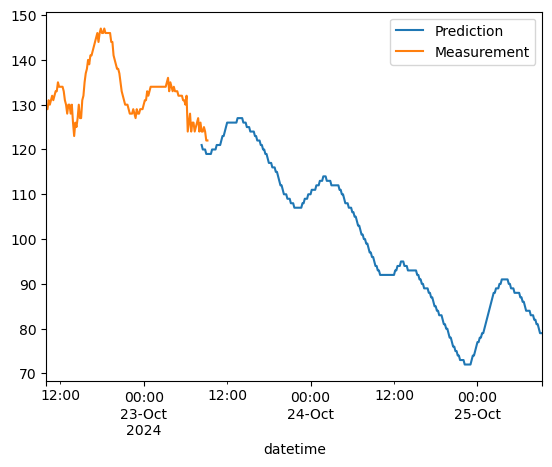

In [14]:
fig, ax = plt.subplots()
df_plot_measurements.plot(color="C0", ax=ax)
df_plot_forecast.plot(color="C1", ax=ax)
ax.legend(["Prediction", "Measurement"])